In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import fft
import seaborn as sns
import pandas as pd

import matplotlib as mpl
mpl.rcParams["font.size"]=15

In [2]:
# definition of root paths
root_dir = '/Users/zcaspar/codes/mit4320/'
fig_dir = '/Users/zcaspar/Documents/Figures_paper2/'

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,lat='lat_bin',**kwargs):
    """
    Plot maps of a given xarray.
    ----------------------------------------------
    Parameters:
    ds : xarray, 2D variable
    colmap : colormap to use in the plot (see list of colormaps on matplotlib), default is 'RdBu_r'
    vlim : tuple, limits of the colorbar (vmin, vmax)
    axes : subplots definition, default is one figure (111)
    lat : str, name of the latitude axis, default is 'lat_bin'
    kwargs : dict, properties of the colorbar (example: {'orientation':'horizontal'})
    """
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    cbar_kwargs = {'fraction':0.02}
    cbar_kwargs.update(**kwargs)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y=lat,ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,#**kwargs,
            cbar_kwargs=cbar_kwargs) #{'fraction':0.02,'label':'energy'}
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    return fig,ax

In [4]:
#Eulerian and Lagrangian energy
hf_dl2 = xr.merge([xr.open_dataset(root_dir+'energy_SSU_hf_binned_dl2.0.nc'),
                   xr.open_dataset(root_dir+'energy_SSV_hf_binned_dl2.0.nc')
                  ]).rename({'lon_bin':'lon_bins','lat_bin':'lat_bins'})

dsL =  xr.open_dataset(root_dir+'L_hf_fit_gauss.nc')
dsE =  xr.open_dataset(root_dir+'E_hf_fit_gauss.nc')

ds_low = xr.merge([xr.open_dataset(root_dir+'energy_SSU_low_binned_dl2.0.nc'),    #low frequency energy in 2° bins
                   xr.open_dataset(root_dir+'energy_SSV_low_binned_dl2.0.nc')])  

dsL_low_mean1 = xr.open_dataset(root_dir+'L_low_fit_mean1.nc')  #Lagrangian low frequency variance in 2° bins

In [5]:
dt = 1/24
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

omega_sn = (omega_S2-omega_M2)/2
tau = np.arange(0,dsL.lags.max()+dt,dt) #time lag
print('Spring-neap cycle : ', 1/(2*omega_sn), 'days')
print('Oscillation after demodulation ( spring-neap cycle /2): ', 1/omega_sn, 'days')

Spring-neap cycle :  14.765294045749723 days
Oscillation after demodulation ( spring-neap cycle /2):  29.530588091499446 days


In [6]:
#### Estimation of k using woa data

vmodes = xr.open_dataset(root_dir+'vmodes_from_woa18.nc')

omega_Earth = 7.2921*1e-5 #rad.s-1
f = 2*omega_Earth*np.sin(2*np.pi*vmodes.lat/360) #rad.s-1
#vmodes.lat
day2sec = 3600*24
rad= 2*np.pi

_k = np.sqrt(((rad*omega/day2sec)**2-(f)**2)/(vmodes.c)**2) #rad/m
L = rad/_k*1e-3
L = L.rename({'lat':'lat_bins','lon':'lon_bins'})

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [7]:
_k = _k.groupby_bins('lon',bins=np.arange(-180,180,2)
                    ).mean().groupby_bins('lat',bins=np.arange(-60,60,2)
                                         ).mean()

In [8]:
def get_lagrangian_energy_loss( bandwidth, ds, U=1, 
                               Ce=None,axis=-1, 
                               full_output=False,
                               _factor_dtau=100,
                               _factor_tau_max=100,
                              ):
    """ compute the lagrangian loss of energy following Caspar-Cohen et al. 2022
    
    Parameters
    ----------
    omega: float
        wave frequency
    bandwidth: float
        filter bandwidth
    ds: xr.Dataset
        Dataset containing T, k, Ubar, Tbar
    Ce: lambda
        Eulerian autocorrelation signature must look like Ce(tau, U, T)
    """
    # util params
    day2sec = 86400
#    U = 1
    #omega0 = (omega[0]+omega[1])/2
    # check all variables are here
    input_variables = ["T", "k", "Ubar", "Tbar"]
    assert all([v in ds for v in input_variables]), \
        "one of T, k, Ubar, Tbar is missing from ds"
    ds = ds.set_coords(input_variables)

    # default autocorrelation
    if Ce is None:
        Ce = lambda tau, U, T: U * np.exp(-np.abs(tau/T)**2) * np.cos(2*np.pi*omega*tau)#(np.cos(2*np.pi*omega[0]*tau) + np.cos(2*np.pi*omega[1]*tau))
        
    # derives Lagrangian
#    sigma = lambda tau, Ub, Tb: Tb*day2sec*Ub*np.sqrt(2*(tau/Tb - (1-np.exp(-np.abs(tau/Tb)))))
    sigma = lambda tau, Ub, Tb: (Tb*day2sec*Ub)*np.sqrt(2*(tau/Tb - (1-np.exp(-np.abs(tau/Tb)))))
    Cl = lambda tau, U, T, k, Ub, Tb: Ce(tau, U, T) * np.exp(- (sigma(tau, Ub, Tb)*k)**2 /2)

    # build lags
    tau_max = T*_factor_tau_max
    dtau = 2*np.pi/omega/_factor_dtau
    ds = ds.assign_coords(tau=("tau", np.arange(0, tau_max, dtau)))
    
    # build covariance
    ds["Ce"] = Ce(ds.tau, U, ds["T"])
    #ds["sigma"] = sigma(ds.tau, ds.Ubar, ds.Tbar)
    #ds["exp_sigma"] = np.exp(- (sigma(ds.tau, ds.Ubar, ds.Tbar)*ds.k)**2 /2)
    ds["Cl"] = Cl(ds.tau, U, ds["T"], ds.k, ds.Ubar, ds.Tbar)
    # build power density spectrum
    N = ds.tau.size
    if axis==-1:
        input_dims_Ce, input_dims_Cl = ["tau"],["tau"]
        output_dims_Ce, output_dims_Cl = ["omega"], ["omega"]
    elif axis==0:
        dim = 'k'
        input_dims_Ce = ["tau"]#[d for d in ds.Ce.dims]
        output_dims_Ce = ["omega"]#+[d for d in ds.Ce.dims[1:]]
    
        input_dims_Cl = ["tau","k"]#[d for d in ds.Cl.dims]
        output_dims_Cl = ["omega","k"]#+[d for d in ds.Cl.dims[1:]]
    print(input_dims_Cl,output_dims_Cl)
    def dct(C,input_dims,output_dims):
        return xr.apply_ufunc(lambda C: fft.dct(C, type=3,axis=axis) * dtau,
                              C,
                              dask="parallelized",
                              input_core_dims=[input_dims],
                              output_core_dims=[output_dims],
                              dask_gufunc_kwargs=dict(output_sizes=dict(omega=N)), #[[N]]
                             )
    
    ds["Ee"] = dct(ds.Ce,input_dims_Ce,output_dims_Ce)
    ds["El"] = dct(ds.Cl,input_dims_Cl,output_dims_Cl)
#    ds["Ee"] = xr.DataArray(fft.dct(ds.Ce.values,type=3,axis=axis)*dtau)
#    ds["El"] = fft.dct(ds.Cl.values,type=3,axis=axis)
    ds["omega"] = (2*np.arange(N)+1)/4/N /dtau
    
    # integrate within filter band
    Ee = (ds.Ee
          .where( np.abs(ds.omega-omega)<bandwidth/2, other=0 )
          .integrate("omega")
         )
    El = (ds.El
          .where( np.abs(ds.omega-omega)<bandwidth/2, other=0 )
          .integrate("omega")
         )
    ds["ratio"] = El/Ee
    if full_output:
        return ds
    else:
        return Ee,El,ds.ratio

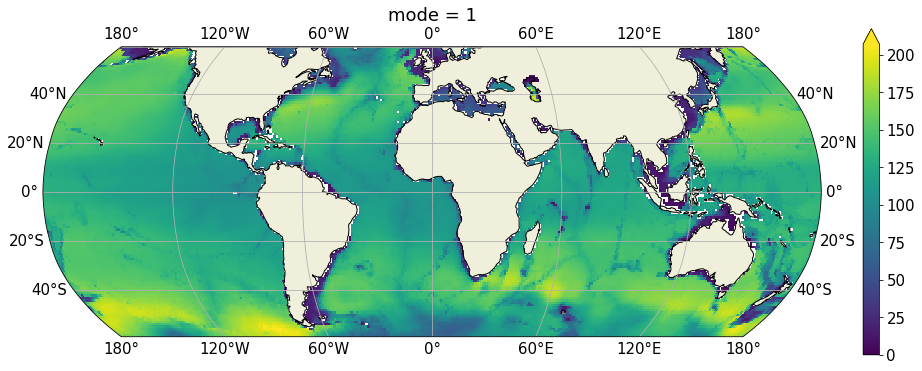

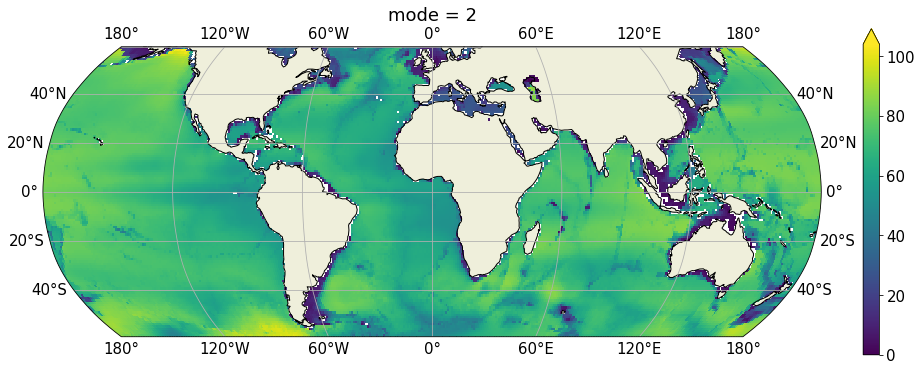

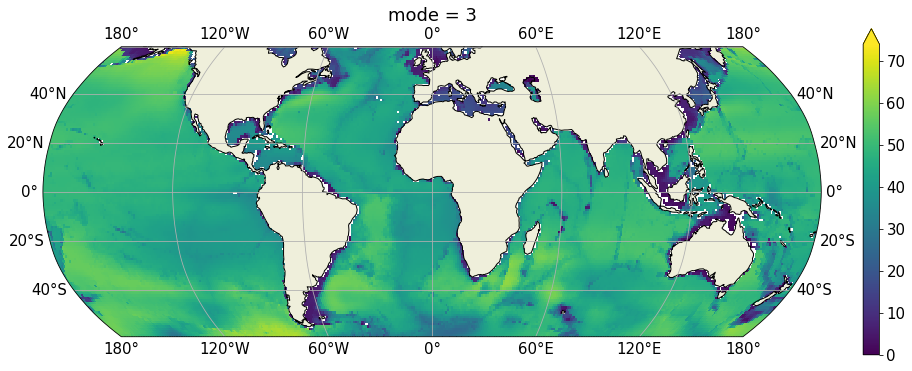

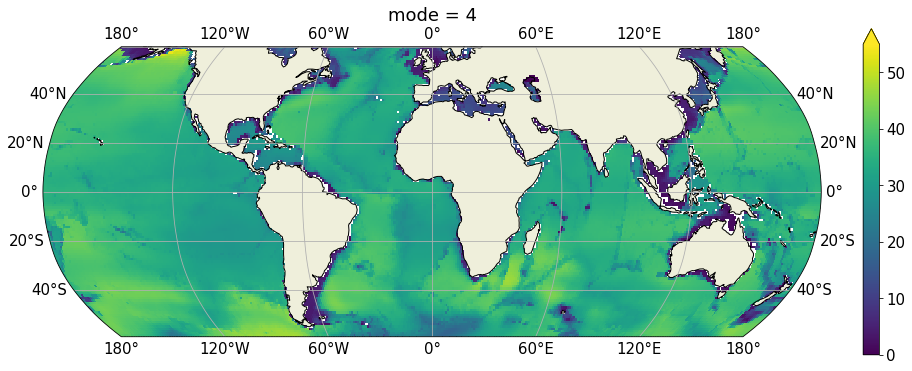

In [9]:
for mode in range(1,6):
    _ds = L.sel(mode=mode).sel(lat_bins=slice(-60,60))
    fig=plt.figure(figsize=(15,6))
    plot_maps(_ds,lat='lat_bins',vlim=(0,np.around(_ds.max().values)),colmap='viridis')

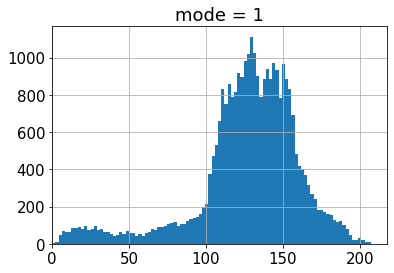

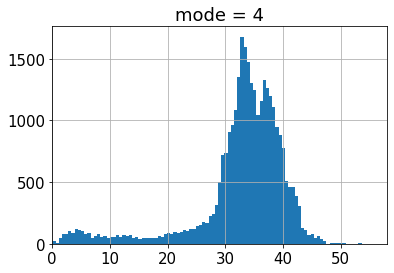

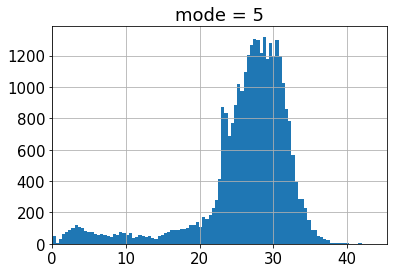

In [16]:
for mode in range(1,6):
    _ds = L.sel(mode=mode).sel(lat_bins=slice(-60,60))
    fig,ax = plt.subplots(figsize=(6,4))
    _ds.plot.hist(ax=ax,bins=100);
    ax.set_xlim(0,None);ax.grid();

In [10]:
# Timescales

Tlbar = dsL_low_mean1.sel(param='T').parameters_SSU.values     # Lagrangian low frequency decorrelation timescale
Te = dsE.sel(param='T').parameters_SSU.values                  # Eulerian incoherence timescale
Tl = dsL.sel(param='T').parameters_SSU.values                  # Lagrangian incoherence timescale

TlbarV = dsL_low_mean1.sel(param='T').parameters_SSV.values    # Lagrangian low frequency decorrelation timescale
TeV = dsE.sel(param='T').parameters_SSV.values                 # Eulerian incoherence timescale
TlV = dsL.sel(param='T').parameters_SSV.values                 # Lagrangian incoherence timescale

T = np.nanmean(Tl)


# Energy
Ulbar = ds_low.L_energy_SSU.values                             # Lagrangian low frequency energy (SSU)
Vlbar = ds_low.L_energy_SSV.values                             # Lagrangian low frequency energy (SSV)

#U = dsE.rr.isel(lags=0).values
Ue = hf_dl2.E_energy_SSU.values                                # Eulerian semidiurnal energy  (SSU)
Ul = hf_dl2.L_energy_SSU.values                                # Lagrangian semidiurnal energy  (SSU)
Ve = hf_dl2.E_energy_SSV.values                                # Eulerian semidiurnal energy  (SSV)
Vl = hf_dl2.L_energy_SSV.values                                # Lagrangian semidiurnal energy  (SSV)
#dsE_out.sel(param='V').parameters.values
#Ul = dsL_out.sel(param='V').parameters.values

#k = _k.sel(mode=1).sel(lat=slice(-60,60))

In [11]:
#New datasets with all necessary parameters

#SSU
ds = xr.Dataset(dict(T=(["lon_bins",'lat_bins'],Te),
                     k=(["lon_bins","lat_bins","mode"],_k.transpose('lon_bins','lat_bins','mode').values),
                     Ubar=(["lon_bins",'lat_bins'], np.sqrt(Ulbar)),
                     Tbar=(["lon_bins",'lat_bins'], Tlbar.T), U=(["lon_bins",'lat_bins'], Ue),
                     lon_bins=(["lon_bins"],hf_dl2.lon_bins.values),lat_bins=(["lat_bins"],hf_dl2.lat_bins.values)))

#SSV
dsV = xr.Dataset(dict(T=(["lon_bins",'lat_bins'],TeV),
                      k=(["lon_bins","lat_bins","mode"],_k.transpose('lon_bins','lat_bins','mode').values),
                      Ubar=(["lon_bins",'lat_bins'], np.sqrt(Vlbar)),
                     Tbar=(["lon_bins",'lat_bins'], TlbarV.T), U=(["lon_bins",'lat_bins'], Ve),
                     lon_bins=(["lon_bins"],hf_dl2.lon_bins.values),lat_bins=(["lat_bins"],hf_dl2.lat_bins.values)))



In [12]:
bandwidth = 0.4

Ee,El,ratio = get_lagrangian_energy_loss( bandwidth, ds, U=ds.U, _factor_tau_max=10)
Ee_V,El_V,ratio_V = get_lagrangian_energy_loss(bandwidth, dsV, U=ds.U, _factor_tau_max=10,axis=-1)

['tau'] ['omega']
['tau'] ['omega']


In [28]:
ds_predicted = xr.Dataset({'Ee':(['lon_bins','lat_bins'],Ee.values),
                           'El':(['lon_bins','lat_bins'],El.sel(mode=2).values),
                           'Ee_V':(['lon_bins','lat_bins'],Ee_V.values),
                           'El_V':(['lon_bins','lat_bins'],El_V.sel(mode=2).values),
            'T':(['lon_bins','lat_bins'],Ee['T'].values),'Tv':(['lon_bins','lat_bins'],Ee_V['T'].values),
           'lon_bins':Ee.lon_bins.values,'lat_bins':Ee.lat_bins.values
           })

In [31]:
ds_predicted.to_netcdf(root_dir+'prediction_mode2.nc')

In [13]:
kwargs = {'orientation':'horizontal','fraction':0.07,'pad':0.06}

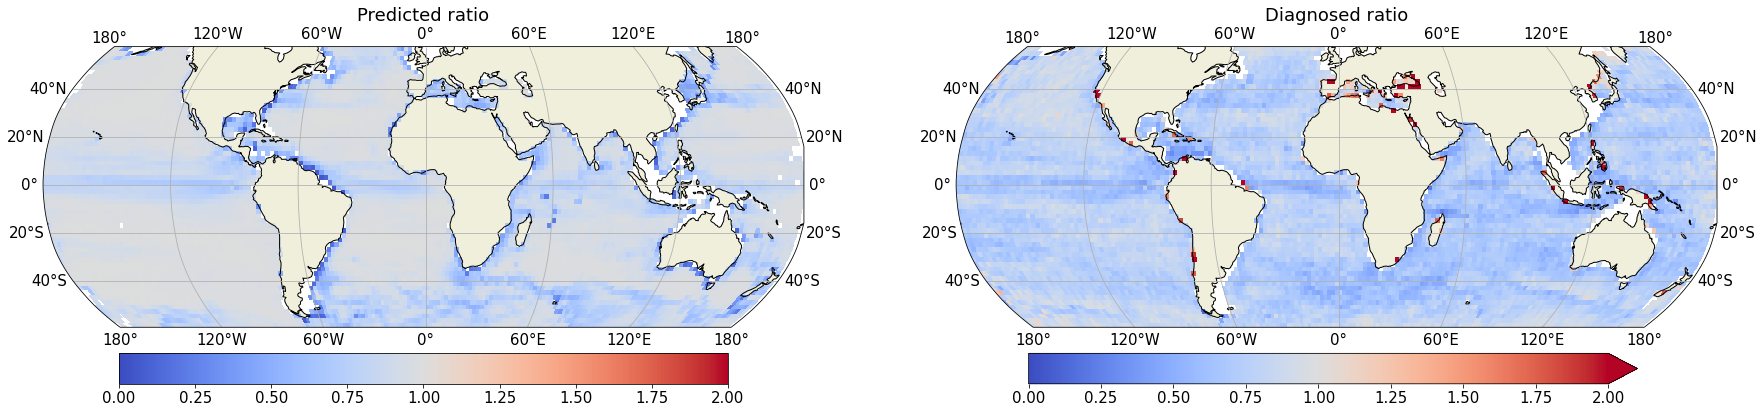

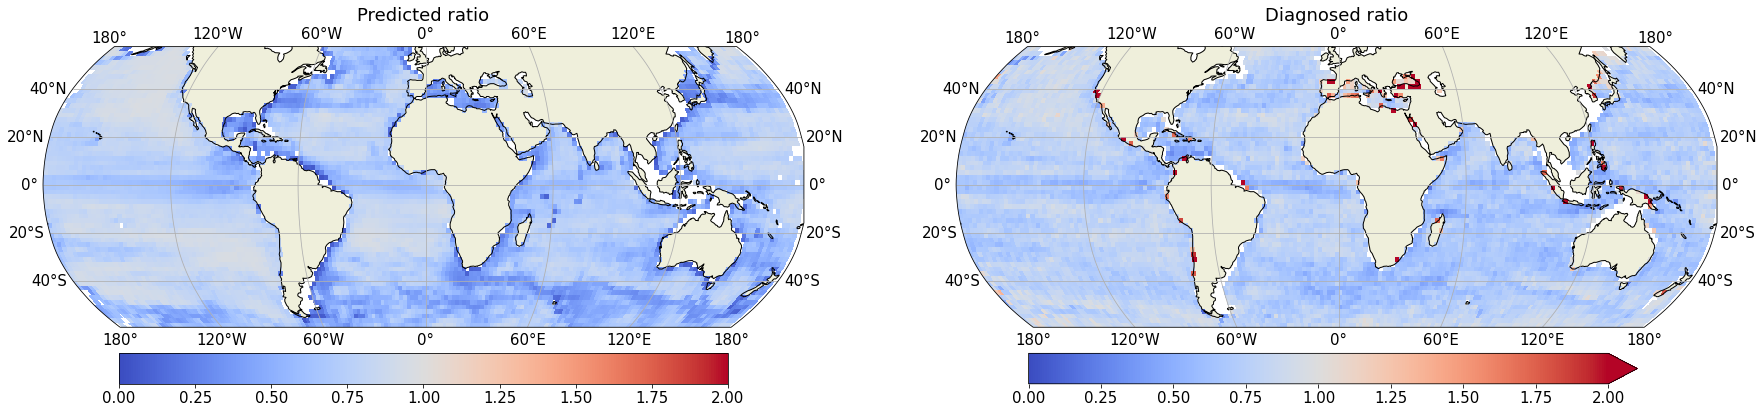

In [23]:
for mode in range(1,6):
    fig=plt.figure(figsize=(30,8))
    fig,ax = plot_maps(((El+El_V)/(Ee+Ee_V)).sel(mode=mode),
                       lat='lat_bins',vlim=(0,2),axes=121,colmap='coolwarm',**kwargs)
    ax.set_title('Predicted ratio')
    #fig=plt.figure(figsize=(15,6))
    fig,ax = plot_maps(((hf_dl2.L_energy_SSU+hf_dl2.L_energy_SSV)/(hf_dl2.E_energy_SSU+hf_dl2.E_energy_SSV)
                       ).where(hf_dl2.waterdepth>500)
              ,lat='lat_bins',vlim=(0,2),axes=122,colmap='coolwarm',**kwargs)
    ax.set_title('Diagnosed ratio')
    #fig=plt.figure(figsize=(15,6))
    #plot_maps((El.sel(mode=mode)/hf_dl2.L_energy_SSU),lat='lat_bins',vlim=(0,2),colmap='coolwarm')

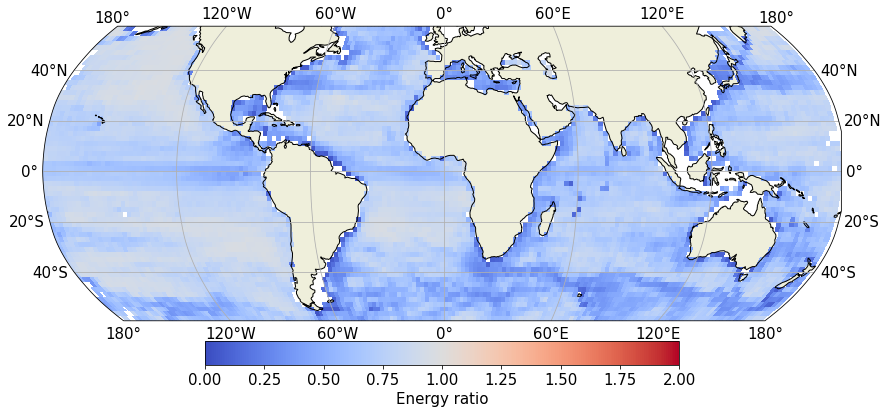

In [22]:
kwargs.update({'label':'Energy ratio'})
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(((El+El_V)/(Ee+Ee_V)).sel(mode=2),lat='lat_bins',vlim=(0,2),colmap='coolwarm',**kwargs)
fig.tight_layout()
fig.savefig(fig_dir+'LE_energy_predicted.png')

In [23]:

fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(((hf_dl2.L_energy_SSU+hf_dl2.L_energy_SSV)/(hf_dl2.E_energy_SSU+hf_dl2.E_energy_SSV)
                       ).where(hf_dl2.waterdepth>500)
                   ,lat='lat_bins',vlim=(0,2),axes=111,colmap='coolwarm',**kwargs)
fig.tight_layout()
fig.savefig(fig_dir+'LE_energy.png')

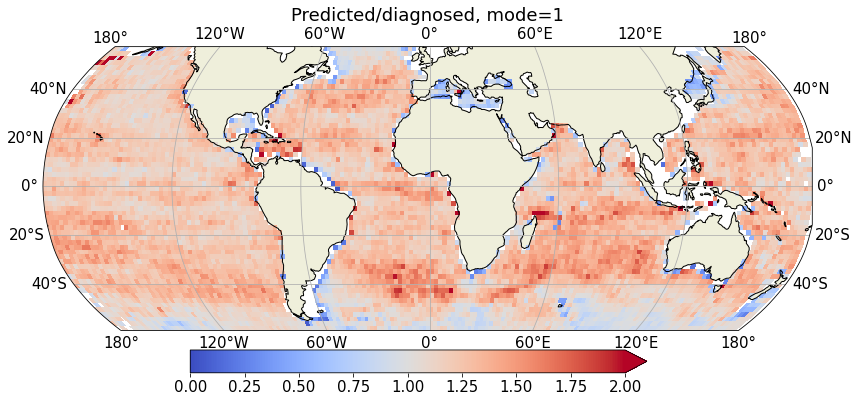

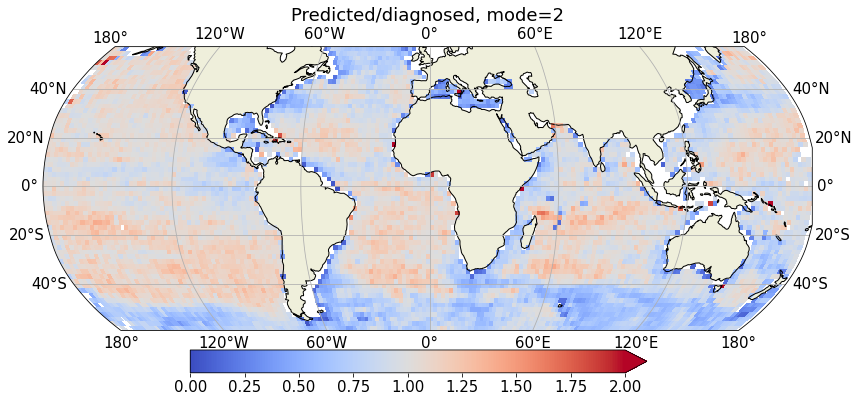

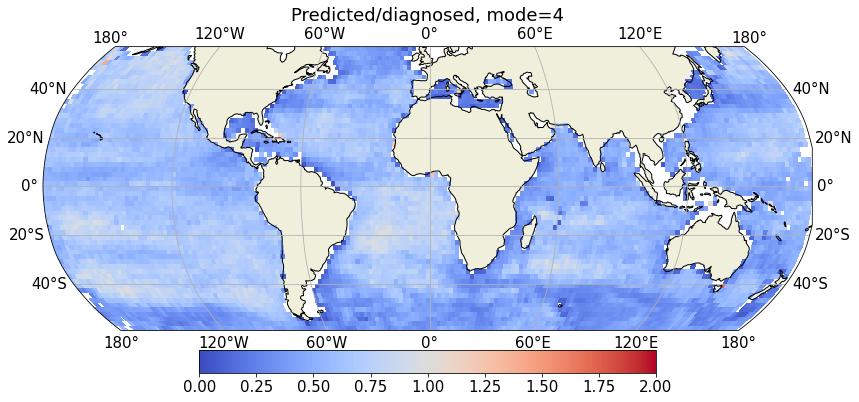

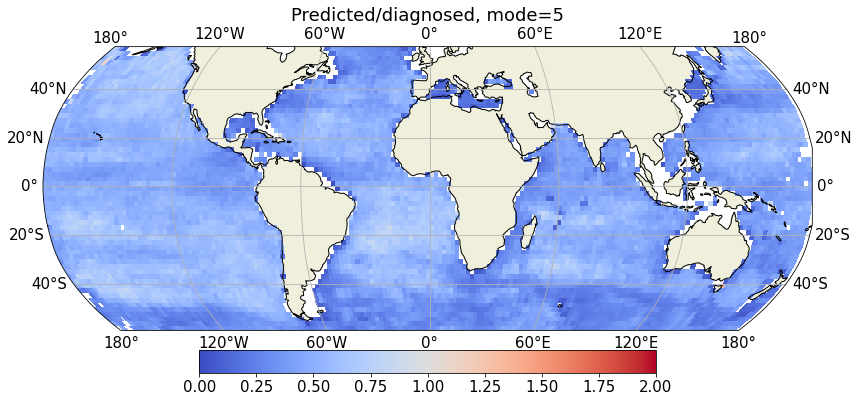

In [24]:
for mode in range(1,6):
    fig=plt.figure(figsize=(15,6))
    fig,ax = plot_maps(((El+El_V)/(Ee+Ee_V)).sel(mode=mode)/((hf_dl2.L_energy_SSU+hf_dl2.L_energy_SSV)/(hf_dl2.E_energy_SSU+hf_dl2.E_energy_SSV)).where(hf_dl2.waterdepth>500)
              ,lat='lat_bins',vlim=(0,2),axes=111,colmap='coolwarm',**kwargs)
    ax.set_title('Predicted/diagnosed, mode=%s'%mode)

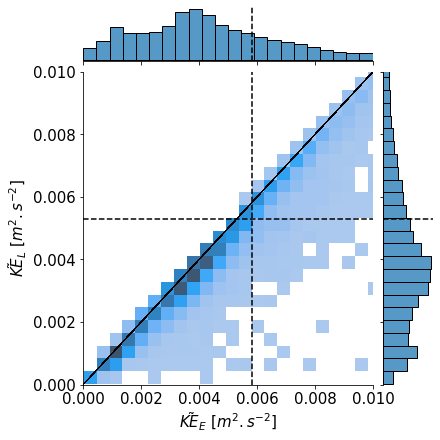

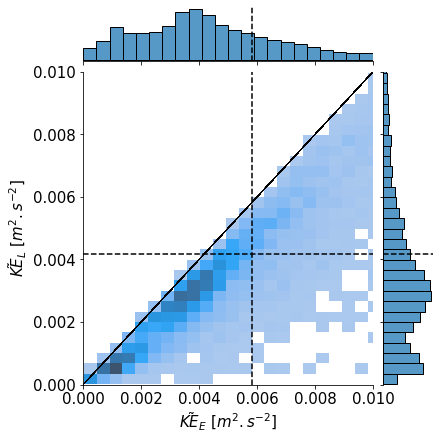

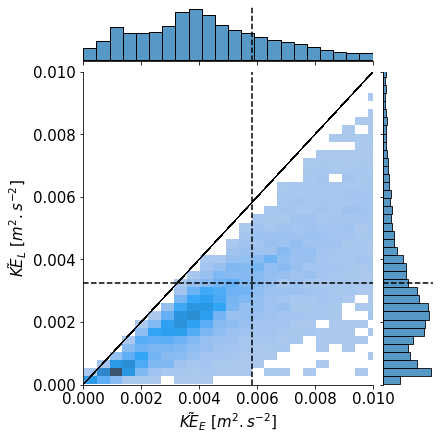

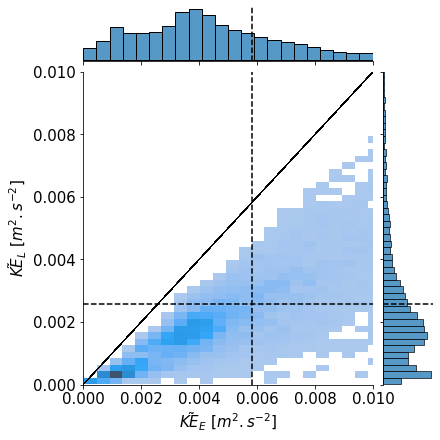

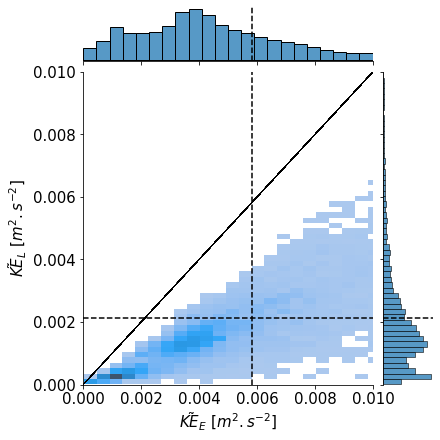

In [44]:
for mode in range(1,6):
    _El = (El+El_V).sel(mode=mode).values.flatten()
    _Ee = (Ee+Ee_V).values.flatten()
    axs = sns.jointplot(x=_Ee,y=_El,kind='hist',xlim=(0,0.01),ylim=(0,0.01))
    axs.set_axis_labels(r'$\tilde{KE}_E$ [$m^2.s^{-2}$]',r'$\tilde{KE}_L$ [$m^2.s^{-2}$]')
    for ax in (axs.ax_joint, axs.ax_marg_x):
        ax.axvline(axs.x[axs.x<0.03].mean(), color='k', ls='--', lw=1.5)
    for ax in (axs.ax_joint, axs.ax_marg_y):
        ax.axhline(axs.y[axs.y<0.03].mean(), color='k', ls='--', lw=1.5)
    for ax in (axs.ax_joint, axs.ax_marg_x):
        ax.plot(axs.x.values,axs.x.values, c='k', lw=0.5)

In [31]:
ds_out = xr.merge([El,Ee])

In [38]:
ds_out = ds_out.stack(space=['lon_bins','lat_bins'])

In [41]:
ds_out

<xarray.Dataset>
Dimensions:   (space: 10561, mode: 6)
Coordinates:
    T         (space) float64 17.33 19.92 18.8 35.81 ... 39.65 46.49 28.4 46.25
    k         (mode, space) float32 3.14e-07 3.285e-07 ... 0.0001921 0.0001846
    Ubar      (space) float64 0.1195 0.2037 0.3504 ... 0.1704 0.1299 0.1297
    Tbar      (space) float64 nan 1.282 4.14 1.547 ... 2.767 1.419 1.64 1.515
  * space     (space) MultiIndex
  - lon_bins  (space) float64 -179.0 -179.0 -179.0 -179.0 ... 177.0 177.0 177.0
  - lat_bins  (space) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
Dimensions without coordinates: mode
Data variables:
    El        (mode, space) float64 nan 0.0007241 ... 0.004797 0.004722
    Ee        (space) float64 0.0008245 0.0007241 0.0006853 ... 0.0102 0.009605

In [70]:
g.plot?

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warn

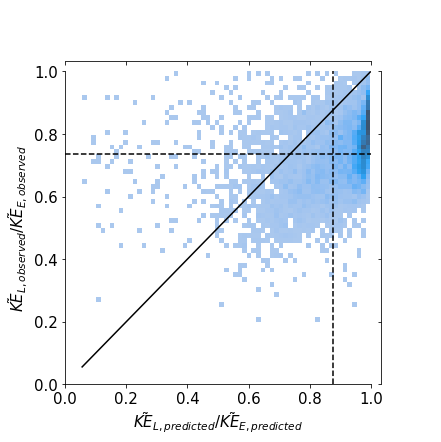

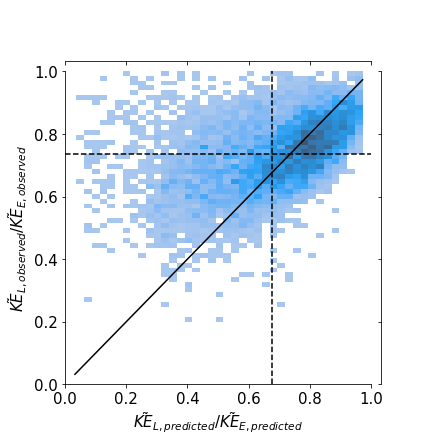

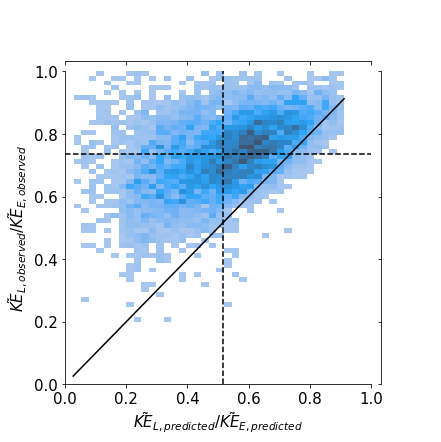

In [80]:
for mode in range(1,4):
    x = ((El+El_V)/(Ee+Ee_V)).sel(mode=mode).values.flatten()
    y = ((hf_dl2.L_energy_SSU+hf_dl2.L_energy_SSV)/(hf_dl2.E_energy_SSU+hf_dl2.E_energy_SSV)
        ).where(hf_dl2.waterdepth>500).values.flatten()
    g = sns.JointGrid(x, y,xlim=(0,1),ylim=(0,1))
    axs = g.plot_joint(sns.histplot)
    axs.set_axis_labels(r'$\tilde{KE}_{L,predicted}/\tilde{KE}_{E,predicted}$',
                        r'$\tilde{KE}_{L,observed}/\tilde{KE}_{E,observed}$');
    axs.ax_joint.axvline(axs.x[axs.x<1].mean(), color='k', ls='--', lw=1.5)
#    for ax in (axs.ax_joint, axs.ax_marg_y):
    axs.ax_joint.axhline(axs.y[axs.y<1].mean(), color='k', ls='--', lw=1.5);
    axs.ax_joint.plot(np.sort(x),np.sort(x),c='k',lw=1.5)
    #for ax in (axs.ax_joint):
    #g.plot(lambda x : x)#, c='k', lw=0.5)

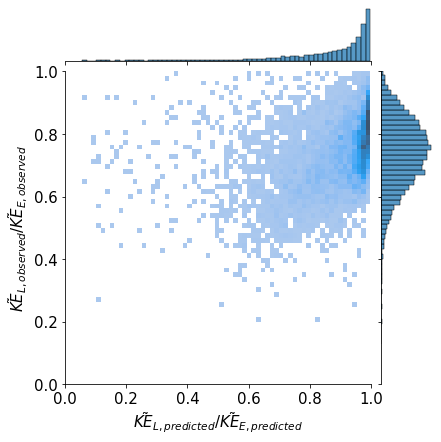

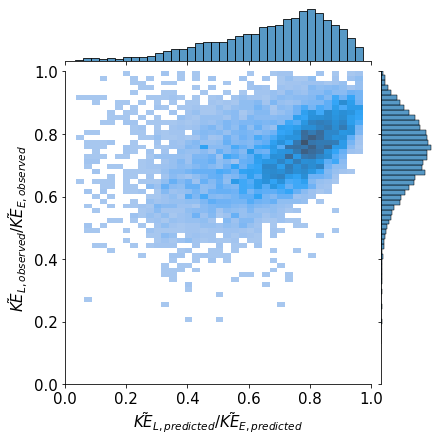

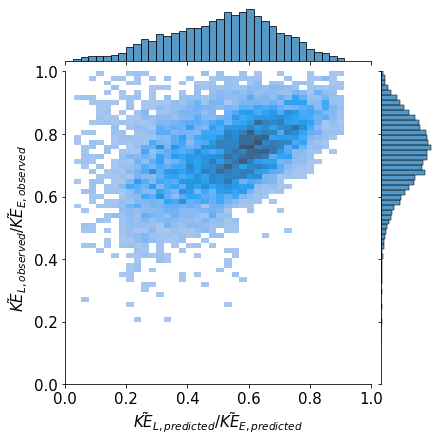

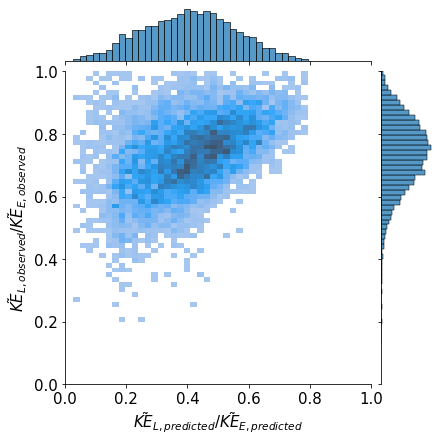

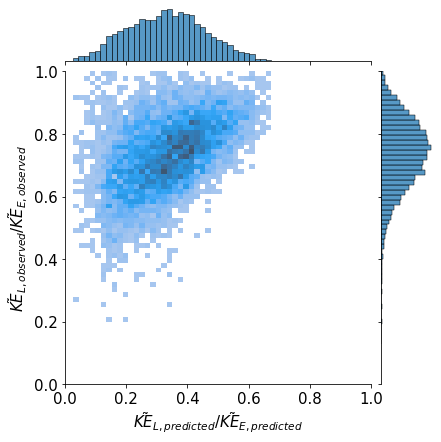

In [45]:
for mode in range(1,6):
    x = ((El+El_V)/(Ee+Ee_V)).sel(mode=mode).values.flatten()
    y = ((hf_dl2.L_energy_SSU+hf_dl2.L_energy_SSV)/(hf_dl2.E_energy_SSU+hf_dl2.E_energy_SSV)
        ).where(hf_dl2.waterdepth>500).values.flatten()
    axs = sns.jointplot(x=x,y=y,kind='hist',xlim=(0,1),ylim=(0,1))
    axs.set_axis_labels(r'$\tilde{KE}_{L,predicted}/\tilde{KE}_{E,predicted}$',
                        r'$\tilde{KE}_{L,observed}/\tilde{KE}_{E,observed}$')

In [36]:
kmean = ((_k.sel(mode=slice(1,6)).cumsum('mode'))/_k.sel(mode=slice(1,6)).mode)

In [37]:
#New datasets with all necessary parameters

#SSU
ds = xr.Dataset(dict(T=(["lon_bins",'lat_bins'],Te),
                     k=(["lon_bins","lat_bins","mode"],kmean.transpose('lon_bins','lat_bins','mode').values),
                     Ubar=(["lon_bins",'lat_bins'], np.sqrt(Ulbar)),
                     Tbar=(["lon_bins",'lat_bins'], Tlbar.T), U=(["lon_bins",'lat_bins'], Ue),
                     lon_bins=(["lon_bins"],hf_dl2.lon_bins.values),lat_bins=(["lat_bins"],hf_dl2.lat_bins.values)))

#SSV
dsV = xr.Dataset(dict(T=(["lon_bins",'lat_bins'],TeV),
                      k=(["lon_bins","lat_bins","mode"],kmean.transpose('lon_bins','lat_bins','mode').values),
                      Ubar=(["lon_bins",'lat_bins'], np.sqrt(Vlbar)),
                     Tbar=(["lon_bins",'lat_bins'], TlbarV.T), U=(["lon_bins",'lat_bins'], Ve),
                     lon_bins=(["lon_bins"],hf_dl2.lon_bins.values),lat_bins=(["lat_bins"],hf_dl2.lat_bins.values)))




In [38]:
bandwidth = 0.4

Ee_mean,El_mean,ratio = get_lagrangian_energy_loss( bandwidth, ds, U=ds.U, _factor_tau_max=10)
Ee_Vmean,El_Vmean,ratio_V = get_lagrangian_energy_loss(bandwidth, dsV, U=ds.U, _factor_tau_max=10,axis=-1)

['tau'] ['omega']
['tau'] ['omega']


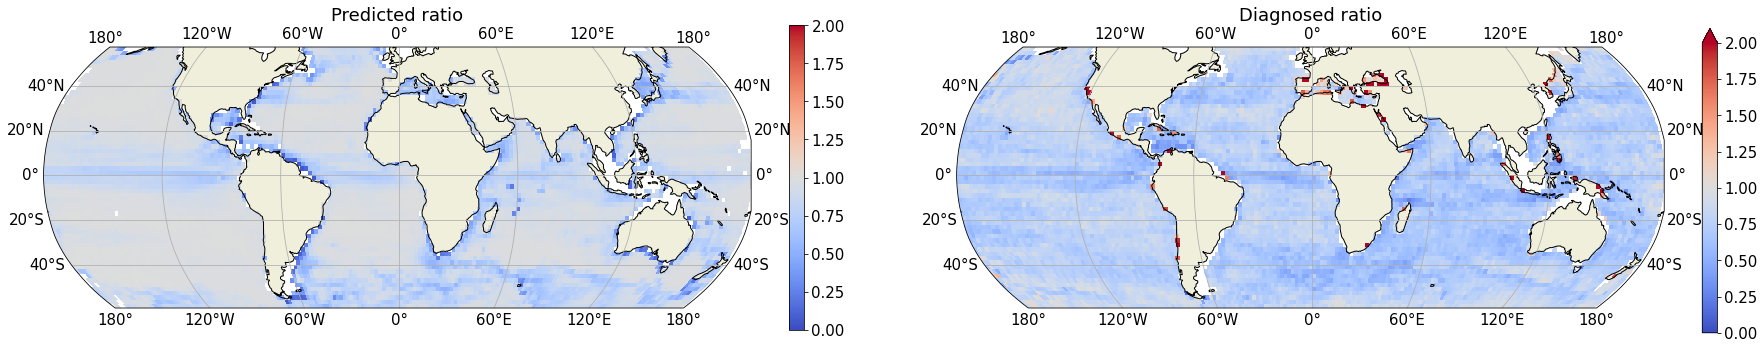

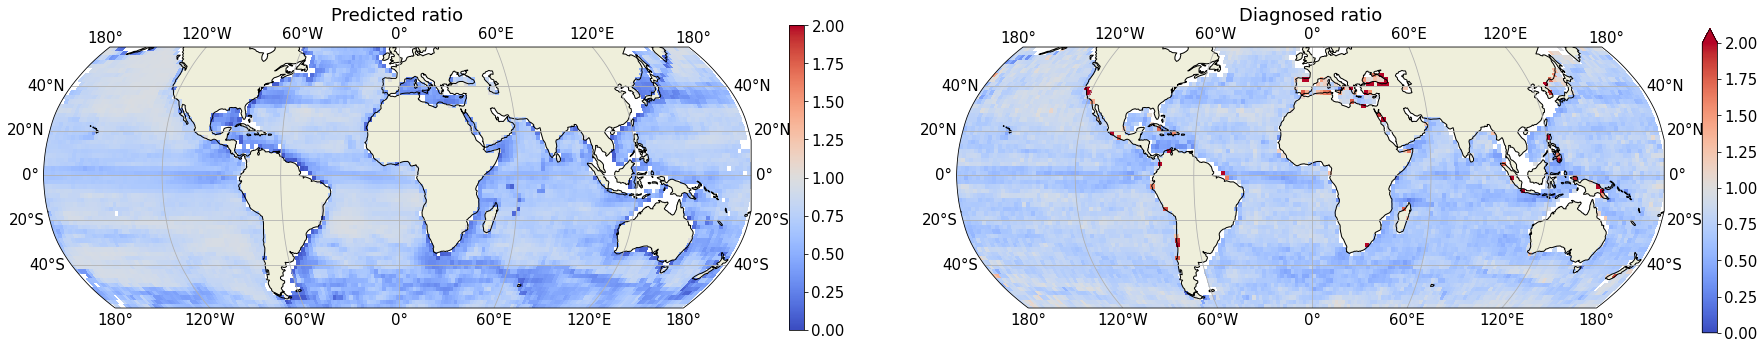

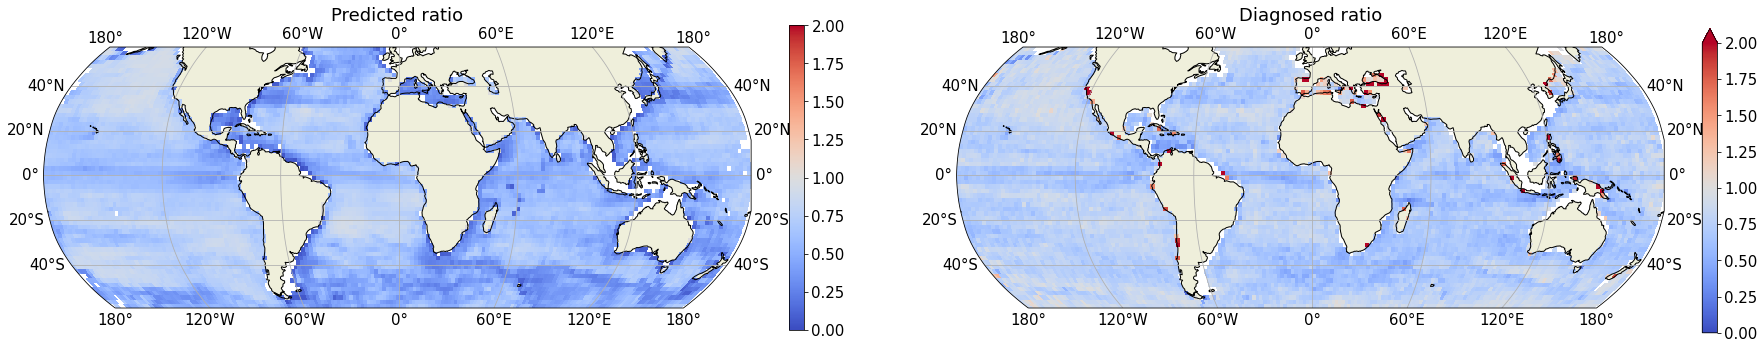

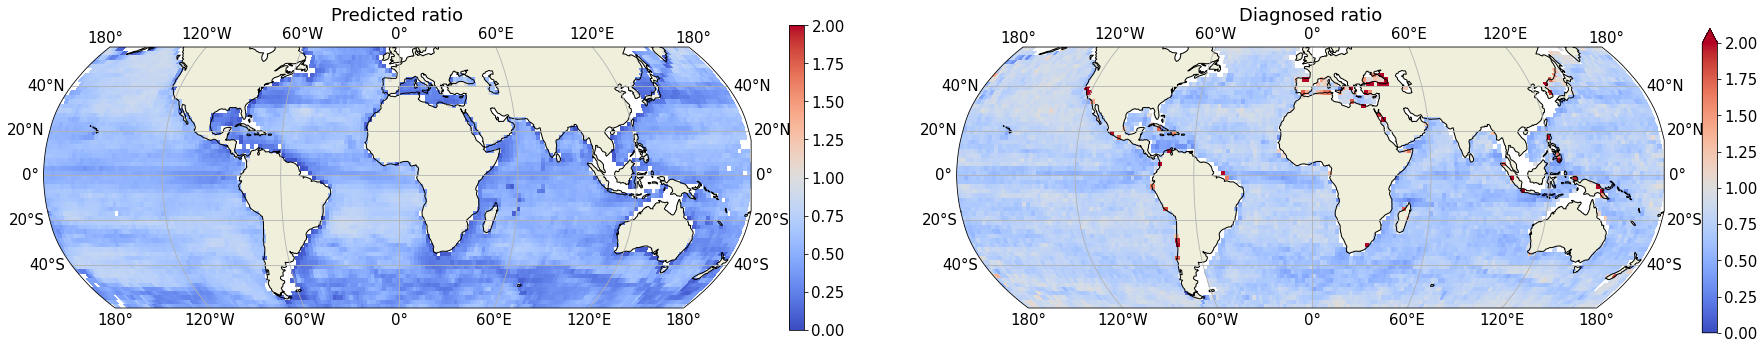

In [51]:
for mode in range(5):
    fig=plt.figure(figsize=(30,8))
    fig,ax = plot_maps(((El_mean+El_Vmean)/(Ee_mean+Ee_Vmean)).sel(mode=mode),lat='lat_bins',vlim=(0,2),axes=121,colmap='coolwarm')
    ax.set_title('Predicted ratio')
    #fig=plt.figure(figsize=(15,6))
    fig,ax = plot_maps(((hf_dl2.L_energy_SSU+hf_dl2.L_energy_SSV)/(hf_dl2.E_energy_SSU+hf_dl2.E_energy_SSV)
                       ).where(hf_dl2.waterdepth>500)
              ,lat='lat_bins',vlim=(0,2),axes=122,colmap='coolwarm')
    ax.set_title('Diagnosed ratio')
    #fig=plt.figure(figsize=(15,6))
    #plot_maps((El.sel(mode=mode)/hf_dl2.L_energy_SSU),lat='lat_bins',vlim=(0,2),colmap='coolwarm')

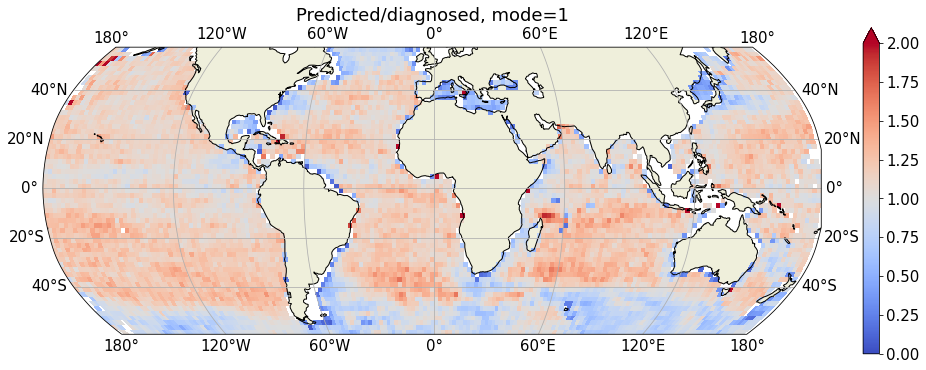

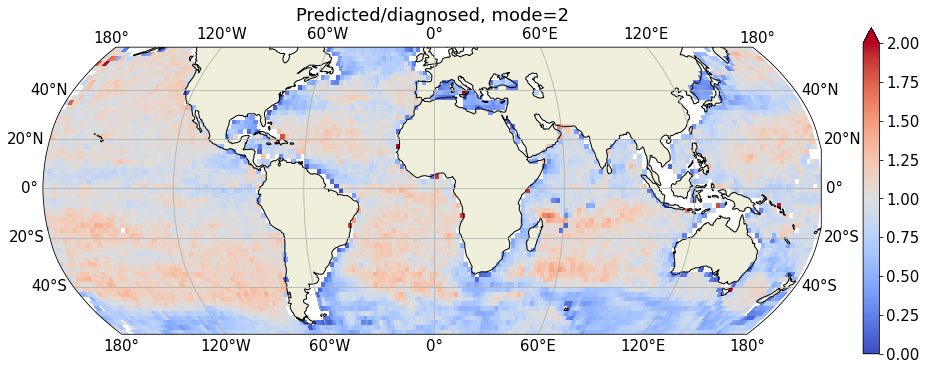

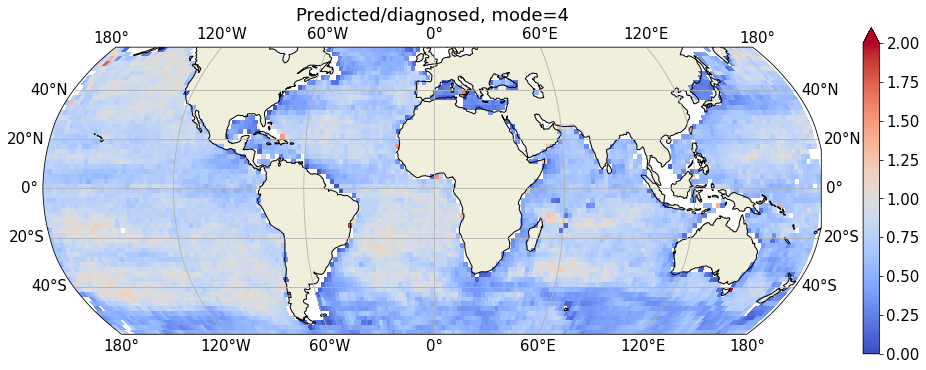

In [50]:
for mode in range(5):
    fig=plt.figure(figsize=(15,6))
    fig,ax = plot_maps(((El_mean+El_Vmean)/(Ee_mean+Ee_Vmean)).sel(mode=mode)/((hf_dl2.L_energy_SSU+hf_dl2.L_energy_SSV)/(hf_dl2.E_energy_SSU+hf_dl2.E_energy_SSV)).where(hf_dl2.waterdepth>500)
              ,lat='lat_bins',vlim=(0,2),axes=111,colmap='coolwarm')
    ax.set_title('Predicted/diagnosed, mode=%s'%mode)

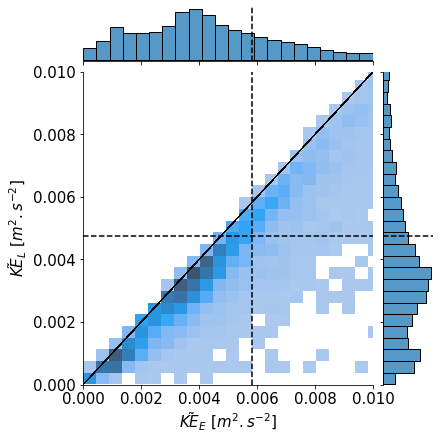

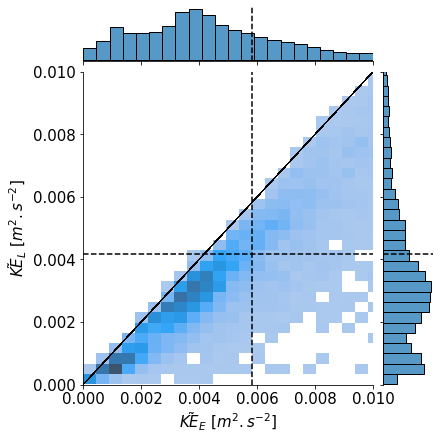

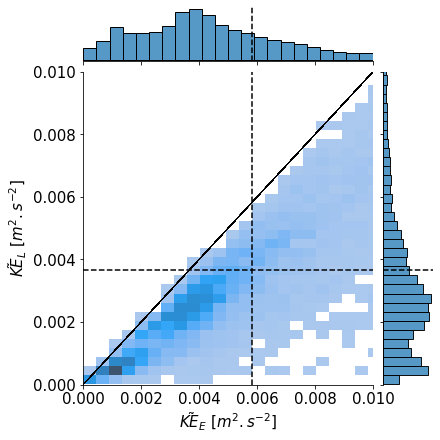

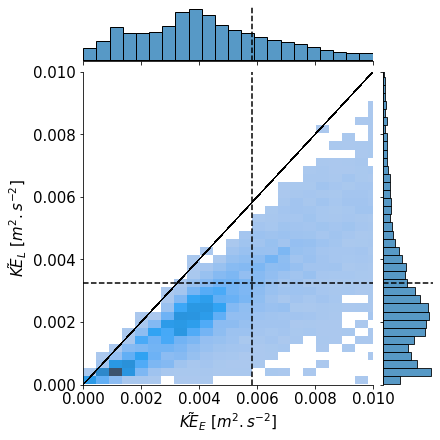

In [53]:
for mode in range(5):
    _El = (El_mean+El_Vmean).sel(mode=mode).values.flatten()
    _Ee = (Ee_mean+Ee_Vmean).values.flatten()
    axs = sns.jointplot(x=_Ee,y=_El,kind='hist',xlim=(0,0.01),ylim=(0,0.01))
    axs.set_axis_labels(r'$\tilde{KE}_E$ [$m^2.s^{-2}$]',r'$\tilde{KE}_L$ [$m^2.s^{-2}$]')
    for ax in (axs.ax_joint, axs.ax_marg_x):
        ax.axvline(axs.x[axs.x<0.03].mean(), color='k', ls='--', lw=1.5)
    for ax in (axs.ax_joint, axs.ax_marg_y):
        ax.axhline(axs.y[axs.y<0.03].mean(), color='k', ls='--', lw=1.5)
    for ax in (axs.ax_joint, axs.ax_marg_x):
        ax.plot(axs.x.values,axs.x.values, c='k', lw=0.5)

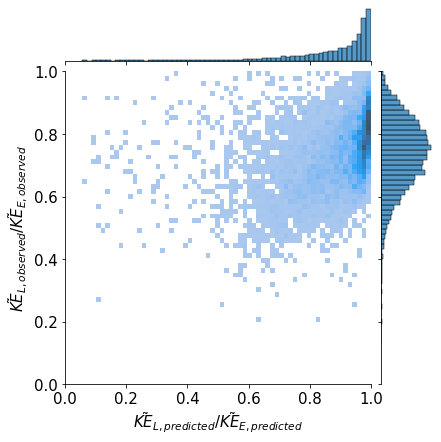

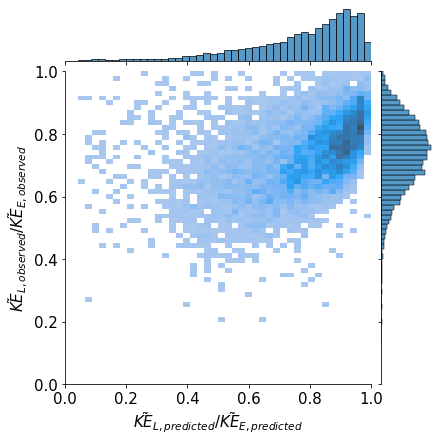

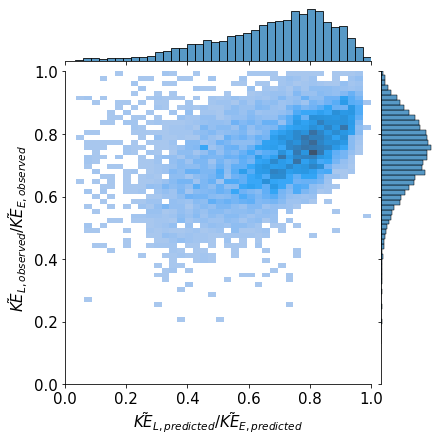

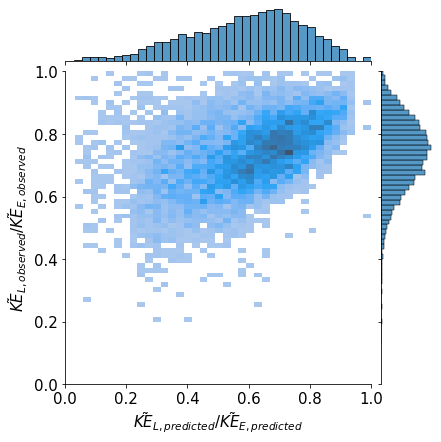

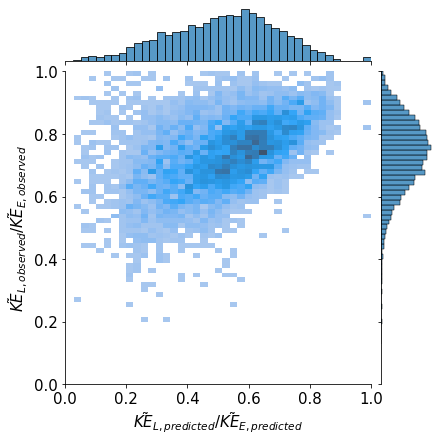

In [54]:
for mode in range(5):
    x = ((El_mean+El_Vmean)/(Ee_mean+Ee_Vmean)).sel(mode=mode).values.flatten()
    y = ((hf_dl2.L_energy_SSU+hf_dl2.L_energy_SSV)/(hf_dl2.E_energy_SSU+hf_dl2.E_energy_SSV)
        ).where(hf_dl2.waterdepth>500).values.flatten()
    axs = sns.jointplot(x=x,y=y,kind='hist',xlim=(0,1),ylim=(0,1))
    axs.set_axis_labels(r'$\tilde{KE}_{L,predicted}/\tilde{KE}_{E,predicted}$',
                        r'$\tilde{KE}_{L,observed}/\tilde{KE}_{E,observed}$')